In [15]:
import torch

print(f"🔥 PyTorch версия: {torch.__version__}")
print(f"🚀 CUDA доступна: {torch.cuda.is_available()}")
print(f"🎮 Название GPU: {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "❌ Нет доступного GPU")


🔥 PyTorch версия: 2.5.1+cu121
🚀 CUDA доступна: True
🎮 Название GPU: NVIDIA GeForce RTX 4080 Laptop GPU


In [16]:
import random
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
from conllu import parse_incr

# Путь к файлу Nerus
nerus_path = "nerus_lenta.conllu"
max_dataset = 10000


def read_nerus(file_path, max_samples=max_dataset): 
    sentences = []
    labels = []
    with open(file_path, "r", encoding="utf-8") as f:
        for i, tokenlist in enumerate(parse_incr(f), start=1):
            tokens = []
            tags = []
            for token in tokenlist:
                form = token["form"]
                misc = token["misc"] 
                
                if not misc:
                    ner_tag = "O"
                else:
                    ner_tag = misc.get("Tag", "O")
                
                tokens.append(form)
                tags.append(ner_tag)
            
            if tokens:
                sentences.append(tokens)
                labels.append(tags)
            
            if max_samples != 0 and i >= max_samples:
                break
    
    return sentences, labels

sentences, labels = read_nerus(nerus_path, max_samples=max_dataset)

# Разделяем на train (80%) и test (20%)
data = list(zip(sentences, labels))
random.shuffle(data)

train_size = int(0.8 * len(data))  # 80% - train, 20% - test
train_data = data[:train_size]
test_data = data[train_size:]

train_sentences, train_labels = zip(*train_data)
test_sentences, test_labels = zip(*test_data)

print(f"🔹 Train size: {len(train_sentences)}, Test size: {len(test_sentences)}")


🔹 Train size: 8000, Test size: 2000


In [17]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        label = label.replace("Tag=", "").replace("g=", "")

        tokenized_word = tokenizer.tokenize(word)

        if not tokenized_word:
            continue  # Пропускаем пустые токены

        # Первый токен получает B-, остальные I-
        tokenized_sentence.extend(tokenized_word)
        main_label = label if label == "O" else "B-" + label.split("-")[-1]
        labels.append(main_label)
        labels.extend(["I-" + label.split("-")[-1] if label != "O" else "O"] * (len(tokenized_word) - 1))

    return tokenized_sentence, labels

# Токенизация выборки
train_tokens, train_labels = zip(*[tokenize_and_preserve_labels(sent, lbl) for sent, lbl in zip(train_sentences, train_labels)])
test_tokens, test_labels = zip(*[tokenize_and_preserve_labels(sent, lbl) for sent, lbl in zip(test_sentences, test_labels)])



In [18]:
def encode_tags(labels, tag2id):
    return [[tag2id[tag] for tag in seq] for seq in labels]

# Создаём словарь меток
unique_tags = set(tag for seq in train_labels for tag in seq)

tag2id = {tag: i for i, tag in enumerate(unique_tags)}
id2tag = {i: tag for tag, i in tag2id.items()}

# Кодируем метки
train_label_ids = encode_tags(train_labels, tag2id)
test_label_ids = encode_tags(test_labels, tag2id)

train_label_tensors = [torch.tensor(seq, dtype=torch.long) for seq in train_label_ids]
test_label_tensors = [torch.tensor(seq, dtype=torch.long) for seq in test_label_ids]

# **Паддинг меток до MAX_LEN**
MAX_LEN = 32  # Максимальная длина
train_label_padded = pad_sequence(train_label_tensors, batch_first=True, padding_value=tag2id["O"])
test_label_padded = pad_sequence(test_label_tensors, batch_first=True, padding_value=tag2id["O"])

# **Обрезаем метки до MAX_LEN, чтобы они совпадали с input_ids**
train_label_padded = train_label_padded[:, :MAX_LEN]
test_label_padded = test_label_padded[:, :MAX_LEN]


In [19]:
print(id2tag)

{0: 'I-PER', 1: 'B-LOC', 2: 'I-ORG', 3: 'O', 4: 'B-ORG', 5: 'I-LOC', 6: 'B-PER'}


In [20]:
from torch.utils.data import DataLoader, TensorDataset

# Токенизация предложений (BERT input_ids и attention_mask)
encoded_inputs = tokenizer([" ".join(sent) for sent in train_sentences], padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
test_encoded_inputs = tokenizer([" ".join(sent) for sent in test_sentences], padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")

# Создаём TensorDataset
train_dataset = TensorDataset(
    encoded_inputs["input_ids"], 
    encoded_inputs["attention_mask"], 
    train_label_padded
)

test_dataset = TensorDataset(
    test_encoded_inputs["input_ids"],
    test_encoded_inputs["attention_mask"],
    test_label_padded
)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [21]:
import torch.nn as nn
import torch
from transformers import BertModel
from torchcrf import CRF

class BERT_CRF(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        emissions = self.classifier(self.dropout(outputs.last_hidden_state))

        if labels is not None:
            mask = attention_mask.bool()  # CRF требует bool mask
            loss = -self.crf(emissions, labels, mask=mask)  # Без permute()
            return loss.mean()  # 🔥 Усредняем loss, чтобы он стал скаляром
        else:
            return self.crf.decode(emissions, mask=attention_mask.bool()) 

# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация модели
model = BERT_CRF("bert-base-multilingual-cased", len(tag2id)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

train_losses = []  # Список для хранения значений потерь

for epoch in range(5):  # Задаём количество эпох
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        loss = model(input_ids, attention_mask, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)  # Средний Loss за эпоху
    train_losses.append(avg_loss)  # Сохраняем значение Loss

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")


Epoch 1: Loss = 20.5526
Epoch 2: Loss = 8.4556
Epoch 3: Loss = 5.2059
Epoch 4: Loss = 4.2806
Epoch 5: Loss = 3.8096


In [22]:
from seqeval.metrics import classification_report

def align_predictions(predictions, labels, attention_mask):
    """ Приводит предсказанные метки к исходным словам. """
    aligned_preds = []
    aligned_labels = []

    for pred_seq, label_seq, mask_seq in zip(predictions, labels, attention_mask):
        true_labels = []
        true_preds = []
        
        for pred, label, mask in zip(pred_seq, label_seq, mask_seq):
            if mask.item() == 1:  # Игнорируем паддинг-токены
                true_labels.append(id2tag[label.item()])
                true_preds.append(id2tag[pred])

        aligned_preds.append(true_preds)
        aligned_labels.append(true_labels)

    return aligned_preds, aligned_labels

def evaluate(model, dataloader, tag2id, id2tag):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            predictions = model(input_ids, attention_mask) 
            aligned_preds, aligned_labels = align_predictions(predictions, labels, attention_mask)

            all_preds.extend(aligned_preds)
            all_labels.extend(aligned_labels)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

# Оцениваем модель
evaluate(model, test_dataloader, tag2id, id2tag)



Classification Report:
              precision    recall  f1-score   support

         LOC       0.90      0.89      0.90       728
         ORG       0.90      0.88      0.89      1273
         PER       0.96      0.92      0.94       945

   micro avg       0.92      0.90      0.91      2946
   macro avg       0.92      0.90      0.91      2946
weighted avg       0.92      0.90      0.91      2946



In [23]:
# Сохранение модели в файл
torch.save({
    'model_state_dict': model.state_dict(),
    'tag2id': tag2id,
    'id2tag': id2tag
}, "bert_crf_model.pth")

print("Модель сохранена в bert_crf_model.pth")


Модель сохранена в bert_crf_model.pth


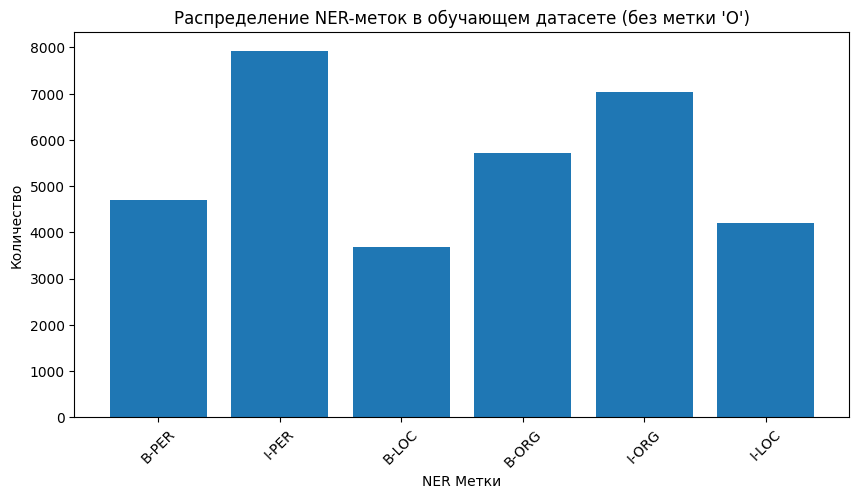

In [24]:
import matplotlib.pyplot as plt
from collections import Counter

# Подсчитываем количество каждого тега в датасете, исключая метку "O"
tag_counts = Counter(tag for seq in train_labels for tag in seq if tag != "O")

# Создаём график
plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel("NER Метки")
plt.ylabel("Количество")
plt.title("Распределение NER-меток в обучающем датасете (без метки 'O')")
plt.xticks(rotation=45)
plt.show()


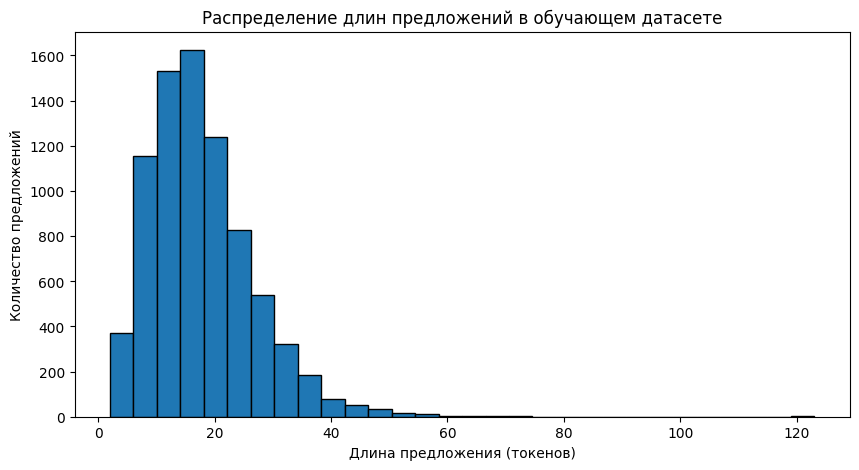

In [25]:
sentence_lengths = [len(sent) for sent in train_sentences]

plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins=30, edgecolor='black')
plt.xlabel("Длина предложения (токенов)")
plt.ylabel("Количество предложений")
plt.title("Распределение длин предложений в обучающем датасете")
plt.show()


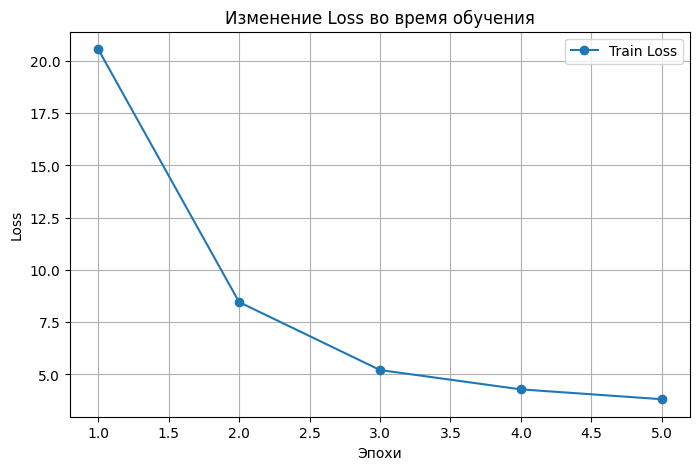

In [26]:
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.title("Изменение Loss во время обучения")
plt.legend()
plt.grid()
plt.show()



🔹 Classification Report:
              precision    recall  f1-score  support
LOC            0.899032  0.892857  0.895934    728.0
ORG            0.902244  0.884525  0.893296   1273.0
PER            0.958011  0.917460  0.937297    945.0
micro avg      0.918985  0.897149  0.907935   2946.0
macro avg      0.919762  0.898281  0.908842   2946.0
weighted avg   0.919339  0.897149  0.908062   2946.0


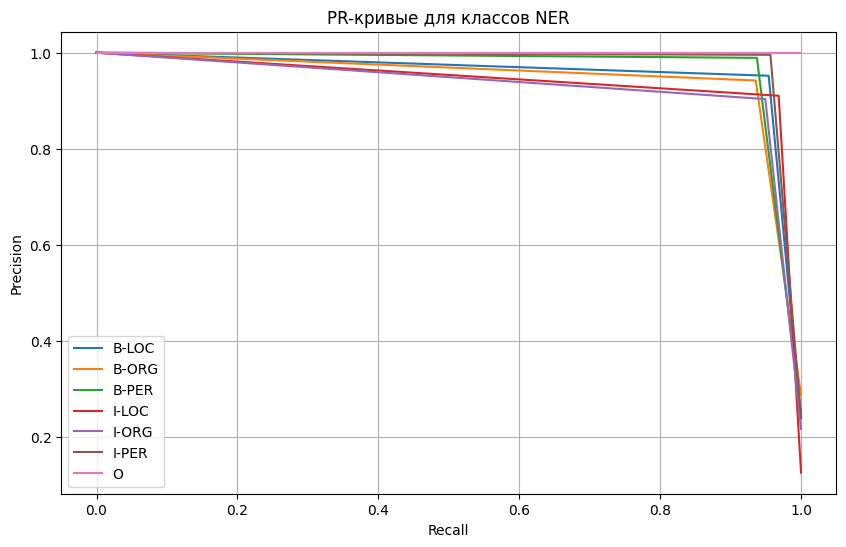

In [28]:
import pandas as pd
from seqeval.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def evaluate(model, dataloader, tag2id, id2tag):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Получаем предсказания модели
            predictions = model(input_ids, attention_mask)
            
            # Конвертируем индексы в теги
            aligned_preds = [[id2tag[idx] for idx in pred] for pred in predictions]
            aligned_labels = [[id2tag[idx.item()] for idx in label] for label in labels]

            # Проверяем, совпадают ли длины предсказанных и истинных меток
            for pred, label in zip(aligned_preds, aligned_labels):
                if len(pred) != len(label):
                    #print(f"⚠️ Несовпадение длины: pred={len(pred)}, label={len(label)}")
                    min_len = min(len(pred), len(label))
                    pred = pred[:min_len]
                    label = label[:min_len]

                all_preds.append(pred)
                all_labels.append(label)

    # Проверяем общую длину
    if len(all_preds) != len(all_labels):
        print(f"❌ Ошибка: all_preds({len(all_preds)}) и all_labels({len(all_labels)}) разной длины!")

    # 🔹 Генерируем отчёт
    report = classification_report(all_labels, all_preds, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    print("\n🔹 Classification Report:")
    print(df_report)

    from sklearn.preprocessing import MultiLabelBinarizer

    # 🔹 Преобразуем `all_labels` и `all_preds` в бинарный формат
    mlb = MultiLabelBinarizer()

    y_true_binarized = mlb.fit_transform(all_labels)
    y_pred_binarized = mlb.transform(all_preds)

    # Получаем список меток (например, ["B-LOC", "I-LOC", "B-PER", ...])
    label_classes = mlb.classes_

    plt.figure(figsize=(10, 6))

    for i, class_name in enumerate(label_classes):
        precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
        plt.plot(recall, precision, label=f"{class_name}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PR-кривые для классов NER")
    plt.legend()
    plt.grid()
    plt.show()

    return df_report

# 🔥 Запускаем оценку модели
df_metrics = evaluate(model, test_dataloader, tag2id, id2tag)



In [29]:
print(f"Количество меток в текущей модели: {len(tag2id)}")
print(f"Список меток: {tag2id}")
print(id2tag)

Количество меток в текущей модели: 7
Список меток: {'I-PER': 0, 'B-LOC': 1, 'I-ORG': 2, 'O': 3, 'B-ORG': 4, 'I-LOC': 5, 'B-PER': 6}
{0: 'I-PER', 1: 'B-LOC', 2: 'I-ORG', 3: 'O', 4: 'B-ORG', 5: 'I-LOC', 6: 'B-PER'}
